In [171]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import contextily as ctx
import time
from datetime import datetime
from pandarallel import pandarallel
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

pandarallel.initialize(progress_bar=True, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
DATA_URL = "https://raw.githubusercontent.com/Claudio9701/mediamap/separate-components/public/grid_data.geojson"

In [94]:
data = gpd.read_file(DATA_URL)

In [4]:
data.head()

,latitude,longitude,OBJECTID,denspob,desc_zoni,geometry
0,8667211.0,275763.0,0,188.937110,COMERCIAL,"POLYGON ((-77.05962 -12.04900, -77.06008 -12.0..."
1,8667261.0,275763.0,1,188.937110,COMERCIAL,"POLYGON ((-77.05962 -12.04855, -77.06007 -12.0..."
2,8667311.0,275763.0,2,111.768367,COMERCIAL,"POLYGON ((-77.05961 -12.04810, -77.06007 -12.0..."
3,8667361.0,275763.0,3,111.768367,COMERCIAL,"POLYGON ((-77.05961 -12.04765, -77.06007 -12.0..."
4,8667411.0,275763.0,4,72.152905,COMERCIAL,"POLYGON ((-77.05960 -12.04720, -77.06006 -12.0..."


In [5]:
data.shape

(506, 6)

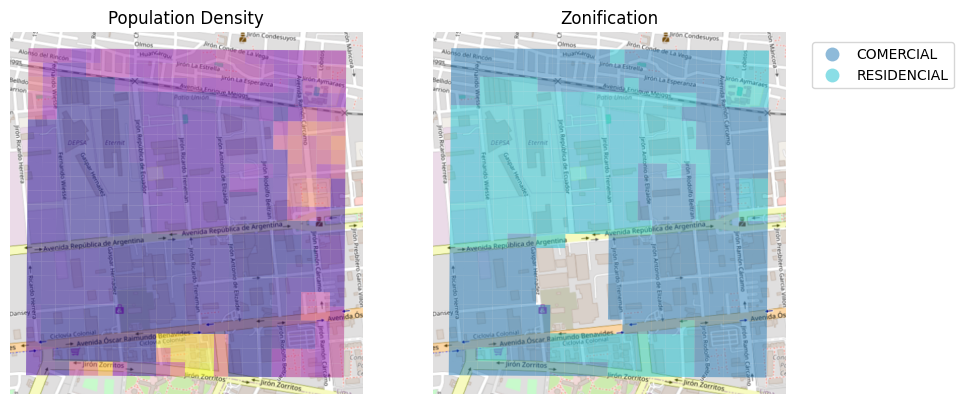

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

data.plot(ax=ax[0], column="denspob", cmap="plasma", alpha=0.5)
ax[0].set_title("Population Density")
data.plot(
    ax=ax[1],
    column="desc_zoni",
    cmap="tab10",
    alpha=0.5,
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.5, 0.99)},
)
ax[1].set_title("Zonification")

for axis in ax:
    axis.set_axis_off()
    ctx.add_basemap(
        axis,
        crs=data.crs.to_string(),
        source=ctx.providers.OpenStreetMap.Mapnik,
        attribution=False,
    )

plt.savefig("images/dense_zone_layers.png", bbox_inches="tight", dpi=300)

plt.show()

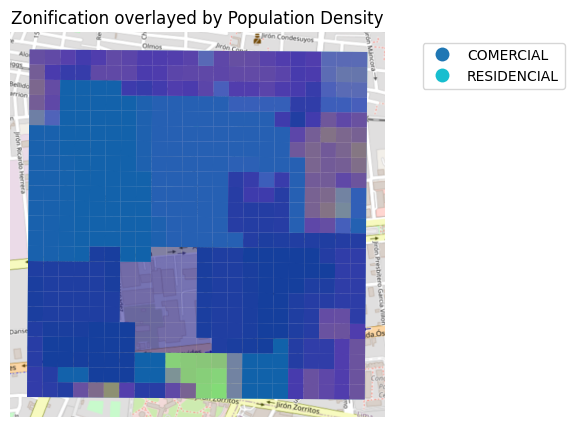

In [185]:
fig, ax = plt.subplots(figsize=(5, 5))

data.plot(
    ax=ax,
    column="desc_zoni",
    cmap="tab10",
    legend=True,
    legend_kwds={"bbox_to_anchor": (1.5, 0.99)},
)
data.plot(ax=ax, column="denspob", cmap="plasma", alpha=0.5)
ax.set_title("Zonification overlayed by Population Density")

ax.set_axis_off()
ctx.add_basemap(
    ax,
    crs=data.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)

plt.show()

In [95]:
# Set simulation parameters
population_size = data["denspob"].sum().round().astype(int)
trips_per_person = 2

origins = data[data["desc_zoni"] == "RESIDENCIAL"].geometry.centroid  # Home
destinations = data[data["desc_zoni"] == "COMERCIAL"].geometry.centroid  # Work

total_trips = population_size * trips_per_person
departure_hour = np.random.normal(7, 0.5, population_size).round(2)
return_hour = np.random.normal(18, 0.5, population_size).round(2)

/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_25490/384711718.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins = data[data["desc_zoni"] == "RESIDENCIAL"].geometry.centroid  # Home
/var/folders/2v/rfkdf8zd7yx_k7lff_2bchrr0000gn/T/ipykernel_25490/384711718.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations = data[data["desc_zoni"] == "COMERCIAL"].geometry.centroid  # Work


In [96]:
print(
    f"""
Simulation Parameters:
---------------------      
Population size: {population_size}
Origins: {origins.shape[0]}
Destinations: {destinations.shape[0]}
Total trips: {total_trips}
Departure times: start {departure_hour.min()} end {departure_hour.max()}
Return times:  start {return_hour.min()} end {return_hour.max()}
"""
)


Simulation Parameters:
---------------------      
Population size: 116952
Origins: 213
Destinations: 261
Total trips: 233904
Departure times: start 4.87 end 9.01
Return times:  start 15.8 end 20.49



In [13]:
# Download the Graph for the data area + 1km buffer using OSMnx
buffer_diameter = 0.01
area_of_interest = data.geometry.unary_union.buffer(buffer_diameter / 2)
start_time = time.time()
G = ox.graph_from_polygon(area_of_interest, network_type="all")
end_time = time.time()
print(f"Downloaded graph in {end_time - start_time} seconds")

Downloaded graph in 0.7319071292877197 seconds


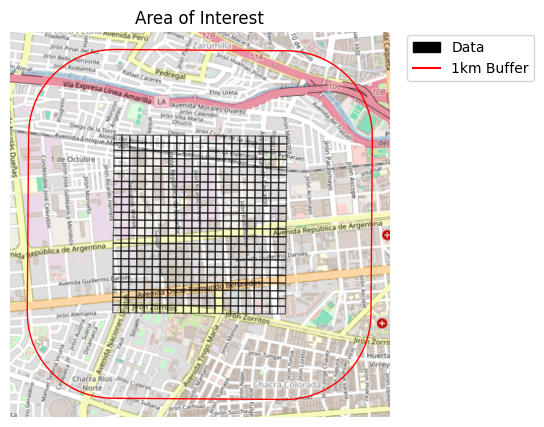

In [184]:
# Plot the area of interest and the data
fig, ax = plt.subplots(figsize=(5, 5))
data.plot(ax=ax, facecolor="none", edgecolor="k", alpha=0.5)
gpd.GeoSeries(area_of_interest).plot(ax=ax, edgecolor="r", facecolor="none")
ax.set_title("Area of Interest")

legend_elements = [
    Patch(facecolor="k", edgecolor="k", label="Data"),
    Line2D(
        [0],
        [0],
        color="r",
        label="1km Buffer",
    ),
]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.4, 1.01))

ax.set_axis_off()
ctx.add_basemap(
    ax,
    crs=data.crs.to_string(),
    source=ctx.providers.OpenStreetMap.Mapnik,
    attribution=False,
)

plt.show()

In [15]:
# Prepare the graph for routing

# impute speed on all edges missing data
hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

# # project the network to UTM
# G_proj = ox.project_graph(G)

In [16]:
# Calculate the nearest nodes to the origins and destinations
start_time = time.time()
origins_nearest_nodes = pd.Series(ox.nearest_nodes(G, origins.x, origins.y))
destinations_nearest_nodes = pd.Series(
    ox.nearest_nodes(G, destinations.x, destinations.y)
)
end_time = time.time()
print(f"Found nearest nodes in {end_time - start_time} seconds")

Found nearest nodes in 0.01827383041381836 seconds


In [19]:
# Stratified sampling origins using the population density
sampled_origins = origins_nearest_nodes.sample(
    weights=data[data["desc_zoni"] == "RESIDENCIAL"]["denspob"],
    n=population_size,
    replace=True,
)
# Random sampling destinations
sampled_destinations = destinations_nearest_nodes.sample(
    n=population_size, replace=True
)

In [20]:
# Get the fastest route using OSMnx
route_to_work = ox.shortest_path(
    G, sampled_origins, sampled_destinations, weight="travel_time", cpus=8
)

In [21]:
route_to_home = ox.shortest_path(
    G, sampled_destinations, sampled_origins, weight="travel_time", cpus=8
)

In [24]:
# Get the graph node to query coordinates after routing
nodes = G.nodes()
nodes = pd.DataFrame.from_dict(nodes, orient="index")
nodes = nodes.rename(columns={0: "x", 1: "y"})
nodes.index.name = "osmid"
# Create a GeoDataFrame from the nodes
nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes.x, nodes.y))
nodes.head()

,y,x,street_count,ref,highway,geometry
osmid,,,,,,
31035190,-12.039221,-77.045444,3,NaN,NaN,POINT (-77.04544 -12.03922)
31035346,-12.035699,-77.045913,3,NaN,NaN,POINT (-77.04591 -12.03570)
31035623,-12.035778,-77.047107,3,10C,motorway_junction,POINT (-77.04711 -12.03578)
31036574,-12.043930,-77.050958,4,NaN,NaN,POINT (-77.05096 -12.04393)
31036580,-12.045422,-77.064872,4,NaN,NaN,POINT (-77.06487 -12.04542)


In [139]:
def generate_trip(route: list, start_time: datetime):
    """
    Generate a trip with OSMnx using the route and the start time.

    Parameters
    ----------
    route : list
        List of nodes that represent the route.
    start_time : datetime
        Start time of the trip.

    """
    if (route_len := len(route)) <= 1:
        return {}

    # Get route information
    route_gdf = ox.utils_graph.route_to_gdf(G, route, "travel_time")
    # Build the timestamp for each route step
    time_deltas = pd.to_timedelta(route_gdf["travel_time"].cumsum(), unit="s")
    timestamps_series = (time_deltas + start_time).astype("int64") // 10**9
    timestamps = timestamps_series.values.tolist()
    timestamps.append(
        datetime.timestamp(start_time)
    )  # Add origin to match route length

    assert route_len == len(
        timestamps
    ), "Route and timestamps must have the same length"

    # Get the coordinates of the nodes in the route
    route_nodes = nodes.loc[route]

    return {
        "start_time": timestamps[0],
        "path": route_nodes[["x", "y"]].values.tolist(),
        "timestamps": timestamps,
    }

In [140]:
# Create a dummy pd.Series to use pandarallel
indexs_series = pd.Series(range(len(route_to_work)))

In [ ]:
# Convert the departure and return times to datetime
today = datetime.today()
start_date = datetime(today.year, today.month, today.day)
work_start_dts = pd.to_timedelta(departure_hour, unit="h") + start_date
home_start_dts = pd.to_timedelta(return_hour, unit="h") + start_date

In [ ]:
# Generate the trips to work and to home

In [142]:
work_trips = indexs_series.parallel_apply(
    lambda i: generate_trip(route=route_to_work[i], start_time=work_start_dts[i])
)

In [148]:
work_trips_df = pd.DataFrame.from_records(work_trips)
work_trips_df.index.name = "person_id"
work_trips_df["type"] = "to_work"

In [149]:
home_trips = indexs_series.parallel_apply(
    lambda i: generate_trip(route=route_to_home[i], start_time=home_start_dts[i])
)

In [150]:
home_trips_df = pd.DataFrame.from_records(home_trips)
home_trips_df.index.name = "person_id"
home_trips_df["type"] = "to_home"

In [151]:
all_trips_df = pd.concat([work_trips_df, home_trips_df])
all_trips_df.sort_values(by=["person_id", "start_time"], inplace=True)

In [152]:
all_trips_df.head()

,start_time,path,timestamps,type
person_id,,,,
0,1.705475e+09,"[[-77.0590472, -12.0411498], [-77.0591066, -12...","[1705475418, 1705475422, 1705475423, 170547542...",to_work
0,1.705514e+09,"[[-77.0536932, -12.0388636], [-77.0536552, -12...","[1705514474, 1705514478, 1705514480, 170551448...",to_home
1,1.705474e+09,"[[-77.0562816, -12.0431819], [-77.056316, -12....","[1705474337, 1705474359, 1705474376, 170547438...",to_work
1,1.705515e+09,"[[-77.0525593, -12.0395342], [-77.0533439, -12...","[1705515058, 1705515069, 1705515077, 170551508...",to_home
2,1.705474e+09,"[[-77.0590472, -12.0411498], [-77.0591066, -12...","[1705473510, 1705473514, 1705473515, 170547351...",to_work


In [155]:
all_trips_df.shape

(233904, 4)

In [156]:
# Save the trips to a JSON file
all_trips_df.to_json("trips.json", orient="records")